In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import kagglehub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Download dataset
path = kagglehub.dataset_download("biratpoudelrocks/nepali-sign-language-character-dataset")
print("Path to dataset files:", path)

100%|██████████| 995M/995M [00:08<00:00, 127MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1


In [3]:
# Debug: List directory structure
print("\nDataset directory structure:")
for root, dirs, files in os.walk(path):
    print(f"Root: {root}, Dirs: {dirs}, Files: {len(files)}")


Dataset directory structure:
Root: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1, Dirs: ['NSL'], Files: 0
Root: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1/NSL, Dirs: ['Random Background', 'Plain Background'], Files: 2
Root: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1/NSL/Random Background, Dirs: ['16', '15', '18', '12', '6', '3', '4', '20', '5', '25', '33', '35', '30', '29', '19', '0', '10', '2', '1', '28', '34', '8', '22', '17', '9', '14', '26', '23', '27', '24', '7', '32', '31', '13', '11', '21'], Files: 0
Root: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1/NSL/Random Background/16, Dirs: [], Files: 500
Root: /root/.cache/kagglehub/datasets/biratpoudelrocks/nepali-sign-language-character-dataset/versions/1/NSL/Random Background/15, Dirs: [], Files: 500
Root: /root/.cach

In [4]:
# Define constants
IMG_SIZE = (64, 64)  # Resize images to 64x64
NUM_CLASSES = 36     # 36 characters
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
# Function to load image paths and labels
def get_image_paths_and_labels(data_dir, background_type):
    image_paths = []
    labels = []
    folder_path = os.path.join(data_dir, 'NSL', background_type)
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Directory not found: {folder_path}")
    for label in range(NUM_CLASSES):
        label_folder = os.path.join(folder_path, str(label))
        if not os.path.exists(label_folder):
            print(f"Warning: Folder {label_folder} not found, skipping...")
            continue
        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

In [6]:
# Load image paths and labels
data_dir = path
try:
    plain_paths, plain_labels = get_image_paths_and_labels(data_dir, 'Plain Background')
    random_paths, random_labels = get_image_paths_and_labels(data_dir, 'Random Background')
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check the dataset path and folder names. Possible fixes:")
    print("- Verify 'NSL/Plain Background' and 'NSL/Random Background' folders exist.")
    print("- Ensure dataset is correctly attached in Kaggle.")
    exit(1)

In [7]:
# Combine datasets
image_paths = plain_paths + random_paths
labels = plain_labels + random_labels

In [8]:
# Convert labels to one-hot encoding
labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

In [9]:
# Split into train and test
train_paths, test_paths, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

In [10]:
# Function to load and preprocess a single image
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0,1]
    return img, label

In [11]:
# Create tf.data.Dataset for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, y_train))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, y_test))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,844 (2.62 MB)

 Trainable params: 687,844 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=test_dataset)

Epoch 1/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4183 - loss: 1.9522 - val_accuracy: 0.9534 - val_loss: 0.1534
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.8801 - loss: 0.3495 - val_accuracy: 0.9667 - val_loss: 0.0956
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9246 - loss: 0.2162 - val_accuracy: 0.9834 - val_loss: 0.0560
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9368 - loss: 0.1799 - val_accuracy: 0.9867 - val_loss: 0.0418
Epoch 5/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9560 - loss: 0.1252 - val_accuracy: 0.9902 - val_loss: 0.0292
Epoch 6/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9641 - loss: 0.1048 - val_accuracy: 0.9902 - val_loss: 0.0276
Epoch 7/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9692 - loss: 0.0912 - val_accuracy: 0.9930 - val_loss: 0.0224
Epoch 8/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9720 -

In [14]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.4f}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9955 - loss: 0.0216

Test accuracy: 0.9945


In [15]:
# Save model
model.save('nepali_sign_language_cnn.h5')

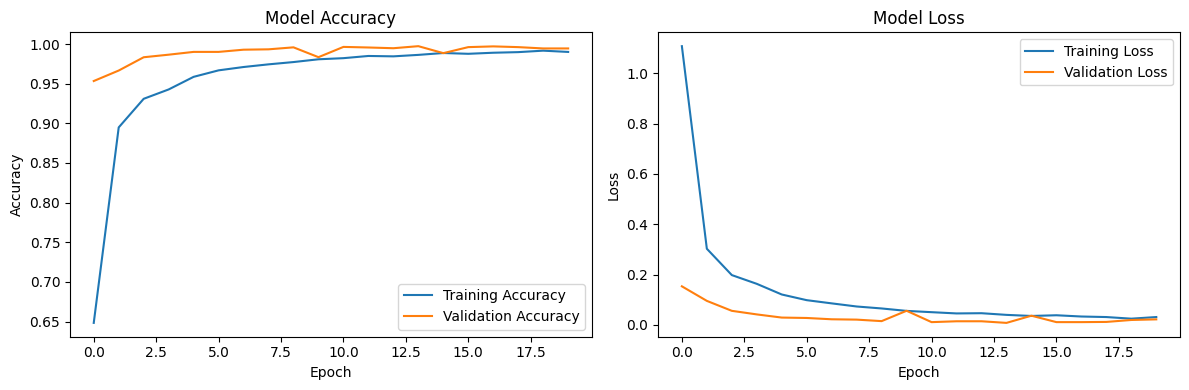

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')